# LightGCN V9b - Hard Negative Mining + Rating Weighted Graph (Rating-aware)

## 핵심 개선사항 (V8b 대비)
- **Hard Negative Mining**: Random이 아닌 어려운 negative 샘플링
- **Rating Weighted Graph**: Rating에 따른 edge weight 차별화
- **Ground Truth**: Rating >= 4만 positive (좋은 구매만 맞추면 정답)
- **Hybrid 추천**: Threshold + Top-K (0~K개 추천)
- **AUC-ROC 평가**: 좋은 구매 vs 비구매 구분 능력
- GPU 최적화 유지 (MPS/CUDA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# CUDA 우선
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. 데이터 전처리 (Rating 무시, Edge 존재만 확인)

In [2]:
df = pd.read_csv('../data/train.csv')

# Rating 정보 포함
print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique items: {df['item'].nunique()}")

# Rating 분포 확인
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# 좋은 구매 정의: Rating >= 4
GOOD_RATING_THRESHOLD = 4
n_good_purchases = (df['rating'] >= GOOD_RATING_THRESHOLD).sum()
print(f"\nGood purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,} ({100*n_good_purchases/len(df):.1f}%)")

# ID 매핑
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

print(f"\nUsers: {n_users}, Items: {n_items}")

Total interactions: 105,139
Unique users: 668
Unique items: 10321

Rating distribution:
rating
0.5     1189
1.0     3254
1.5     1564
2.0     7929
2.5     5473
3.0    21676
3.5    12224
4.0    28831
4.5     8174
5.0    14825
Name: count, dtype: int64

Good purchases (rating >= 4): 51,830 (49.3%)

Users: 668, Items: 10321


In [3]:
# User별 interaction count 및 K값 계산
user_interaction_count = df.groupby('user_idx').size().to_dict()

MAX_K = 100  # K 상한선 (너무 많은 추천 방지)

def get_k_for_user(count):
    """User별 추천 개수 K 계산 (상한선 적용)"""
    if count <= 10:
        return 2  # Cold user: 무조건 2개
    k = max(2, int(count * 0.2))  # 20% of interactions
    return min(k, MAX_K)  # 상한선 적용

user_k = {u: get_k_for_user(c) for u, c in user_interaction_count.items()}

# 통계
k_values = list(user_k.values())
print(f"User K values statistics (MAX_K={MAX_K}):")
print(f"  Min K: {min(k_values)}")
print(f"  Max K: {max(k_values)}")
print(f"  Mean K: {np.mean(k_values):.2f}")
print(f"  Median K: {np.median(k_values):.2f}")

# Cold users (≤10 interactions)
cold_users = sum(1 for c in user_interaction_count.values() if c <= 10)
print(f"\nCold users (≤10 interactions): {cold_users} ({100*cold_users/n_users:.1f}%)")

# Users hitting MAX_K
capped_users = sum(1 for u, k in user_k.items() if k == MAX_K)
print(f"Users with K=MAX_K: {capped_users} ({100*capped_users/n_users:.1f}%)")

User K values statistics (MAX_K=100):
  Min K: 4
  Max K: 100
  Mean K: 24.74
  Median K: 14.00

Cold users (≤10 interactions): 0 (0.0%)
Users with K=MAX_K: 41 (6.1%)


In [4]:
# Train/Val/Test Split (70/15/15)
# 핵심 변경: Rating >= 4인 edge만 Val/Test로 분할
# Rating < 4인 edge는 모두 Train에 포함 (그래프 학습용)

train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx]
    
    # 좋은 구매 (rating >= 4)와 나쁜 구매 분리
    good_purchases = user_df[user_df['rating'] >= GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    bad_purchases = user_df[user_df['rating'] < GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    
    # 나쁜 구매는 모두 Train에 포함 (그래프 학습용, 평가 X)
    if len(bad_purchases) > 0:
        train_data.append(bad_purchases[['user_idx', 'item_idx']])
    
    # 좋은 구매만 Train/Val/Test로 분할
    n_good = len(good_purchases)
    
    if n_good >= 3:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_end = int(0.7 * n_good)
        val_end = train_end + int(0.15 * n_good)
        
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(good_purchases.iloc[:train_end][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[train_end:val_end][['user_idx', 'item_idx']])
        test_data.append(good_purchases.iloc[val_end:][['user_idx', 'item_idx']])
    elif n_good == 2:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(good_purchases.iloc[:1][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[1:][['user_idx', 'item_idx']])
    elif n_good == 1:
        train_data.append(good_purchases[['user_idx', 'item_idx']])
    # n_good == 0: 좋은 구매 없음, train graph에만 나쁜 구매 포함

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame(columns=['user_idx', 'item_idx'])
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame(columns=['user_idx', 'item_idx'])

print(f"Train edges (all purchases for graph): {len(train_df):,}")
print(f"Val edges (good purchases only): {len(val_df):,}")
print(f"Test edges (good purchases only): {len(test_df):,}")

# 통계
n_total_good = n_good_purchases
n_val_test = len(val_df) + len(test_df)
print(f"\nGood purchases in Val/Test: {n_val_test:,} / {n_total_good:,} ({100*n_val_test/n_total_good:.1f}%)")

Train edges (all purchases for graph): 89,294
Val edges (good purchases only): 7,480
Test edges (good purchases only): 8,365

Good purchases in Val/Test: 15,845 / 51,830 (30.6%)


In [5]:
# Pre-computed tensors
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)

# User가 train에서 선택한 items (추천에서 제외용)
user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

print(f"Train tensors ready: {len(train_users):,} edges")

Train tensors ready: 89,294 edges


In [6]:
# Rating Weighted Graph 구축 (Train edges only)
def build_rating_weighted_graph():
    """
    Rating에 따른 edge weight 차별화
    높은 rating = 더 강한 신호 = 더 큰 weight
    """
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # train_df에 rating 컬럼이 없을 수 있음 (V8b 분할 방식)
    # 원본 df에서 rating 가져오기
    ratings = []
    for u, i in zip(users, items):
        rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
        ratings.append(rating[0] if len(rating) > 0 else 3)  # default 3
    ratings = np.array(ratings)
    
    # Rating factor: rating 1→0.55, 2→0.7, 3→0.85, 4→1.0, 5→1.15
    rating_factors = 0.4 + 0.15 * ratings
    
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    # Rating factors도 양방향으로 복제
    rating_factors_both = np.concatenate([rating_factors, rating_factors])
    
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    # 기존 degree normalization * rating factor
    base_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    rating_weight = torch.FloatTensor(rating_factors_both)
    edge_weight = base_weight * rating_weight
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_rating_weighted_graph()
print(f"Rating Weighted Graph: {edge_index.shape[1]:,} edges")

# Rating weight 통계
print(f"\nRating weight statistics:")
print(f"  Min: {edge_weight.min().item():.4f}")
print(f"  Max: {edge_weight.max().item():.4f}")
print(f"  Mean: {edge_weight.mean().item():.4f}")

Rating Weighted Graph: 178,588 edges

Rating weight statistics:
  Min: 0.0007
  Max: 0.2571
  Mean: 0.0138


## 2. LightGCN 모델

In [7]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
    
    def forward(self, edge_index, edge_weight):
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(0, row.unsqueeze(1).expand(-1, self.emb_dim), messages)
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]

def bpr_loss(pos_scores, neg_scores):
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()

## 3. Training & Evaluation

In [8]:
def fast_sample_negatives(batch_size, num_neg=4):
    """Vectorized random negative sampling (baseline)"""
    neg_items = torch.randint(0, n_items, (batch_size, num_neg))
    return neg_items

@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    """
    Hard Negative Mining: 높은 점수의 비구매 item 샘플링
    - Random보다 더 informative한 학습 신호 제공
    - 모델이 "헷갈리는" item에 집중
    """
    batch_size = len(pos_users)
    
    # 1. 10배 많은 candidate 생성
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    
    # 2. 각 user-candidate 점수 계산
    user_expanded = user_emb[pos_users].unsqueeze(1)  # (B, 1, D)
    item_candidates = item_emb[candidates]  # (B, num_candidates, D)
    scores = (user_expanded * item_candidates).sum(dim=2)  # (B, num_candidates)
    
    # 3. 상위 num_neg개 선택 (가장 어려운 것)
    _, top_indices = scores.topk(num_neg, dim=1)
    hard_negs = candidates.gather(1, top_indices)
    
    return hard_negs

# Negative sampling 방식 선택
USE_HARD_NEGATIVE = True
HARD_NEG_RATIO = 0.5  # 50% hard, 50% random (curriculum 효과)

print(f"Negative Sampling: {'Hard Negative Mining' if USE_HARD_NEGATIVE else 'Random'}")
if USE_HARD_NEGATIVE:
    print(f"  Hard/Random ratio: {HARD_NEG_RATIO:.0%} / {1-HARD_NEG_RATIO:.0%}")

Negative Sampling: Hard Negative Mining
  Hard/Random ratio: 50% / 50%


In [9]:
@torch.no_grad()
def evaluate_user_wise_topk(model, eval_df, sample_users=100):
    """
    User-wise Top-K 평가
    각 user별로 K개의 추천을 하고, 실제 positive가 포함되었는지 확인
    """
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # Sample users for evaluation
    eval_users = eval_df['user_idx'].unique()
    if len(eval_users) > sample_users:
        eval_users = np.random.choice(eval_users, sample_users, replace=False)
    
    precisions, recalls, hits = [], [], []
    
    for user_idx in eval_users:
        # User의 실제 positive items (val/test)
        actual_items = set(eval_df[eval_df['user_idx'] == user_idx]['item_idx'].values)
        if len(actual_items) == 0:
            continue
        
        # User가 train에서 이미 선택한 items (제외)
        train_items_set = user_train_items[int(user_idx)]
        
        # 후보: train에서 선택하지 않은 모든 items
        candidate_items = [i for i in range(n_items) if i not in train_items_set]
        if len(candidate_items) == 0:
            continue
        
        # Score all candidates
        candidate_tensor = torch.LongTensor(candidate_items).to(device)
        user_tensor = torch.full((len(candidate_items),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[candidate_tensor]).sum(dim=1)
        
        # Top-K selection
        K = user_k[int(user_idx)]
        K = min(K, len(candidate_items))  # K가 후보보다 클 수 없음
        
        _, top_k_indices = torch.topk(scores, K)
        top_k_items = set([candidate_items[idx.item()] for idx in top_k_indices])
        
        # Metrics
        hits_count = len(top_k_items & actual_items)
        precision = hits_count / K if K > 0 else 0
        recall = hits_count / len(actual_items) if len(actual_items) > 0 else 0
        hit = 1.0 if hits_count > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        hits.append(hit)
    
    return np.mean(precisions), np.mean(recalls), np.mean(hits)

In [10]:
# 학습 설정
EMB_DIM = 32
N_LAYERS = 2
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024
NUM_NEG = 4

print(f"Training config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  lr: {LR}")
print(f"  weight_decay: {WEIGHT_DECAY}")
print(f"  epochs: {EPOCHS}")

Training config:
  emb_dim: 32
  n_layers: 2
  lr: 0.005
  weight_decay: 1e-05
  epochs: 50


In [11]:
model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {'loss': [], 'precision': [], 'recall': [], 'hit': []}
best_recall = 0
n_train = len(train_users)

# Pre-move to GPU
train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)

print(f"Training with Hard Negative Mining + Rating Weighted Graph...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        
        # Forward pass (embedding 계산)
        u_emb, i_emb = model(edge_index, edge_weight)
        
        # Hard Negative Mining + Random (혼합)
        if USE_HARD_NEGATIVE:
            n_hard = int(NUM_NEG * HARD_NEG_RATIO)
            n_random = NUM_NEG - n_hard
            
            # Hard negatives (현재 embedding 기반)
            if n_hard > 0:
                hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
            else:
                hard_negs = None
            
            # Random negatives
            if n_random > 0:
                random_negs = fast_sample_negatives(len(batch_idx), n_random).to(device)
            else:
                random_negs = None
            
            # Combine
            if hard_negs is not None and random_negs is not None:
                neg_i = torch.cat([hard_negs, random_negs], dim=1)
            elif hard_negs is not None:
                neg_i = hard_negs
            else:
                neg_i = random_negs
        else:
            neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        # Score 계산
        pos_scores = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
        neg_scores = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
        
        loss = bpr_loss(pos_scores, neg_scores)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    
    if (epoch + 1) % 5 == 0:
        prec, rec, hit = evaluate_user_wise_topk(model, val_df, sample_users=200)
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['hit'].append(hit)
        
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} | "
              f"Prec@K: {prec:.4f} | Recall@K: {rec:.4f} | Hit@K: {hit:.4f}")
        
        if rec > best_recall:
            best_recall = rec
            torch.save(model.state_dict(), 'best_lightgcn_v9b.pt')

elapsed = time.time() - start_time
print(f"\nTraining time: {elapsed/60:.1f} minutes")
print(f"Best Recall@K: {best_recall:.4f}")

Training with Hard Negative Mining + Rating Weighted Graph...
Epoch   5 | Loss: 0.5791 | Prec@K: 0.0599 | Recall@K: 0.1510 | Hit@K: 0.5650
Epoch  10 | Loss: 0.5527 | Prec@K: 0.0711 | Recall@K: 0.1794 | Hit@K: 0.5750
Epoch  15 | Loss: 0.5378 | Prec@K: 0.0685 | Recall@K: 0.1726 | Hit@K: 0.5750
Epoch  20 | Loss: 0.5289 | Prec@K: 0.0726 | Recall@K: 0.1854 | Hit@K: 0.6250
Epoch  25 | Loss: 0.5227 | Prec@K: 0.0887 | Recall@K: 0.2320 | Hit@K: 0.6300
Epoch  30 | Loss: 0.5179 | Prec@K: 0.0742 | Recall@K: 0.1841 | Hit@K: 0.6100
Epoch  35 | Loss: 0.5146 | Prec@K: 0.0671 | Recall@K: 0.1786 | Hit@K: 0.5400
Epoch  40 | Loss: 0.5124 | Prec@K: 0.0756 | Recall@K: 0.2055 | Hit@K: 0.5850
Epoch  45 | Loss: 0.5102 | Prec@K: 0.0718 | Recall@K: 0.1934 | Hit@K: 0.5900
Epoch  50 | Loss: 0.5092 | Prec@K: 0.0709 | Recall@K: 0.1896 | Hit@K: 0.5950

Training time: 5.1 minutes
Best Recall@K: 0.2320


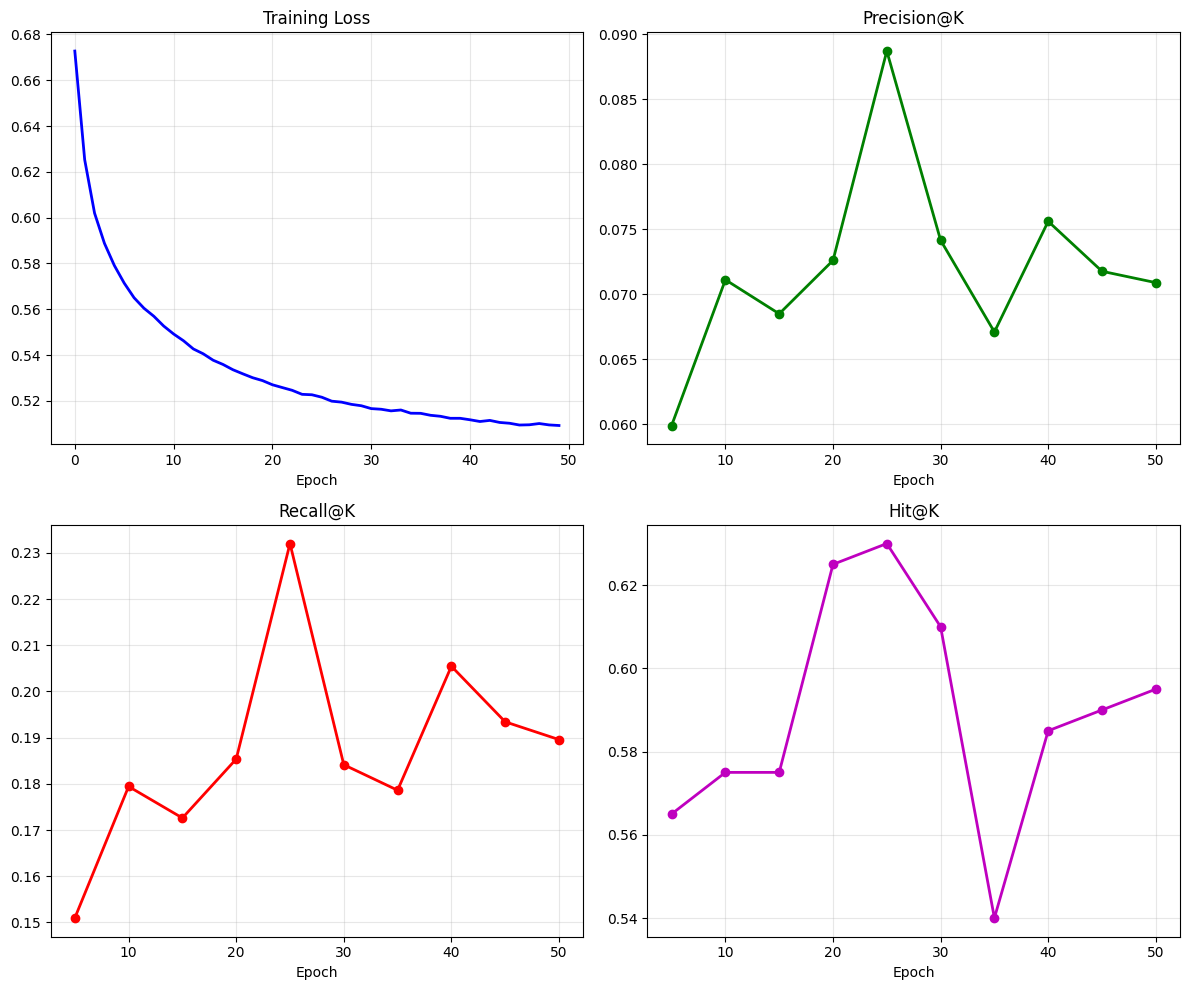

In [12]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(alpha=0.3)

epochs_val = np.arange(5, EPOCHS+1, 5)[:len(history['precision'])]
axes[0, 1].plot(epochs_val, history['precision'], 'g-o', linewidth=2)
axes[0, 1].set_title('Precision@K')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(epochs_val, history['recall'], 'r-o', linewidth=2)
axes[1, 0].set_title('Recall@K')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(epochs_val, history['hit'], 'm-o', linewidth=2)
axes[1, 1].set_title('Hit@K')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Test Set 평가

In [13]:
# Load best model
model.load_state_dict(torch.load('best_lightgcn_v9b.pt'))
model.eval()

with torch.no_grad():
    u_emb, i_emb = model(edge_index, edge_weight)

# Test set 전체 평가 (기존 Top-K only) - 참고용
test_prec, test_rec, test_hit = evaluate_user_wise_topk(model, test_df, sample_users=500)

print("Test Set Performance (User-wise Top-K only) - For reference:")
print(f"  Precision@K: {test_prec:.4f}")
print(f"  Recall@K: {test_rec:.4f}")
print(f"  Hit@K: {test_hit:.4f}")
print("  → 무조건 K개 추천했을 때의 성능")

Test Set Performance (User-wise Top-K only) - For reference:
  Precision@K: 0.1029
  Recall@K: 0.2099
  Hit@K: 0.6420
  → 무조건 K개 추천했을 때의 성능


In [14]:
# AUC-ROC 평가 + Threshold 튜닝
print("Step 1: Calculating AUC-ROC...")

# Positive samples: val edges
val_u_gpu = torch.LongTensor(val_df['user_idx'].values).to(device)
val_i_gpu = torch.LongTensor(val_df['item_idx'].values).to(device)
val_pos_scores = (u_emb[val_u_gpu] * i_emb[val_i_gpu]).sum(dim=1).cpu().numpy()

# Negative samples: random (user, item) pairs not in train/val/test
print("Generating negative samples (excluding train/val/test edges)...")
val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

n_neg_samples = len(val_df)
neg_users, neg_items = [], []
sample_count = 0
while sample_count < n_neg_samples:
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    # Exclude train, val, test edges
    if item_idx not in user_train_items[user_idx] and (user_idx, item_idx) not in val_test_edges:
        neg_users.append(user_idx)
        neg_items.append(item_idx)
        sample_count += 1

neg_u_gpu = torch.LongTensor(neg_users).to(device)
neg_i_gpu = torch.LongTensor(neg_items).to(device)
val_neg_scores = (u_emb[neg_u_gpu] * i_emb[neg_i_gpu]).sum(dim=1).cpu().numpy()

# AUC-ROC
all_scores = np.concatenate([val_pos_scores, val_neg_scores])
all_labels = np.concatenate([np.ones(len(val_pos_scores)), np.zeros(len(val_neg_scores))])

val_auc_roc = roc_auc_score(all_labels, all_scores)
print(f"\nValidation AUC-ROC: {val_auc_roc:.4f}")
print(f"  → 1.0 = 완벽한 구분, 0.5 = 랜덤")
print(f"  → 모델이 O/X를 얼마나 잘 구분하는지 측정")

# Score 분포 확인
print(f"\nScore distributions:")
print(f"  Positive (val) scores: mean={val_pos_scores.mean():.4f}, std={val_pos_scores.std():.4f}")
print(f"  Negative scores: mean={val_neg_scores.mean():.4f}, std={val_neg_scores.std():.4f}")

Step 1: Calculating AUC-ROC...
Generating negative samples (excluding train/val/test edges)...

Validation AUC-ROC: 0.9235
  → 1.0 = 완벽한 구분, 0.5 = 랜덤
  → 모델이 O/X를 얼마나 잘 구분하는지 측정

Score distributions:
  Positive (val) scores: mean=1.2834, std=0.6605
  Negative scores: mean=0.1312, std=0.3568


Step 2: Finding optimal threshold for F1 maximization...

Optimal Threshold (F1 Maximization):
  Threshold: 0.4835
  Precision: 0.8674
  Recall: 0.8790
  F1 Score: 0.8732
  O ratio: 50.7%


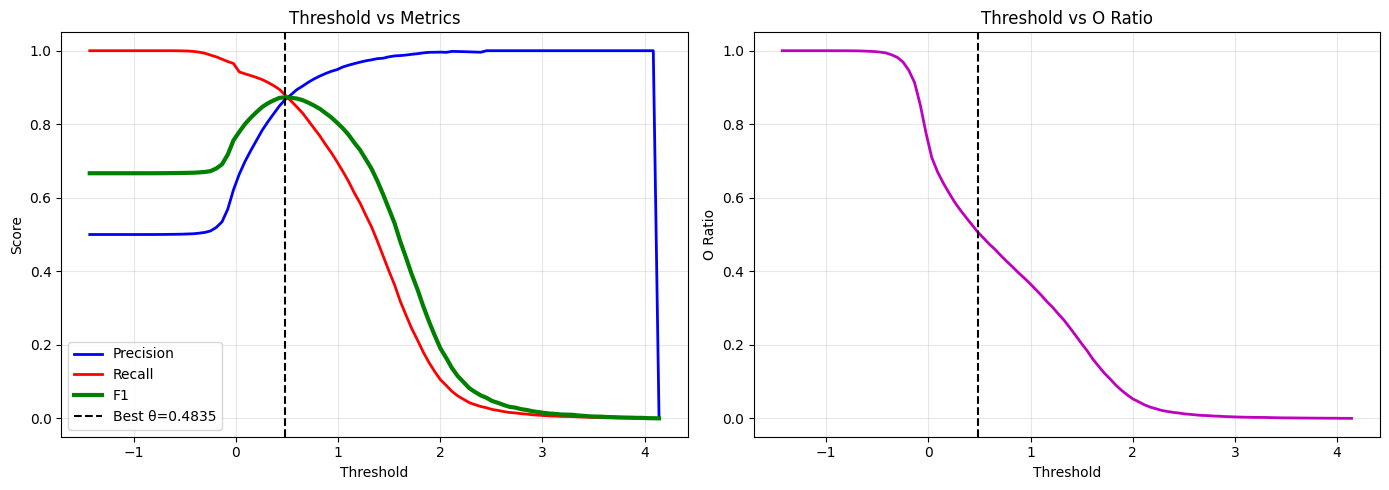


Threshold saved: OPTIMAL_THRESHOLD = 0.4835


In [15]:
# Step 2: Threshold 튜닝 (F1 최대화)
print("Step 2: Finding optimal threshold for F1 maximization...")
from sklearn.metrics import precision_score, recall_score, f1_score

# 다양한 threshold 시도
thresholds = np.linspace(all_scores.min(), all_scores.max(), 100)
best_f1, best_th = 0, 0
best_prec, best_rec = 0, 0

results_list = []
for th in thresholds:
    preds = (all_scores > th).astype(int)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    o_ratio = preds.mean()
    
    results_list.append({
        'threshold': th,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'o_ratio': o_ratio
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_prec = prec
        best_rec = rec

print(f"\nOptimal Threshold (F1 Maximization):")
print(f"  Threshold: {best_th:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall: {best_rec:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

# O ratio at best threshold
preds_at_best = (all_scores > best_th).astype(int)
o_ratio_best = preds_at_best.mean()
print(f"  O ratio: {o_ratio_best*100:.1f}%")

# 시각화
results_df = pd.DataFrame(results_list)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], 'g-', label='F1', linewidth=3)
axes[0].axvline(x=best_th, color='k', linestyle='--', label=f'Best θ={best_th:.4f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Threshold vs Metrics')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(results_df['threshold'], results_df['o_ratio'], 'm-', linewidth=2)
axes[1].axvline(x=best_th, color='k', linestyle='--')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('O Ratio')
axes[1].set_title('Threshold vs O Ratio')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save threshold
OPTIMAL_THRESHOLD = best_th
print(f"\nThreshold saved: OPTIMAL_THRESHOLD = {OPTIMAL_THRESHOLD:.4f}")

In [16]:
def predict_hybrid(test_input_df, threshold):
    """
    Hybrid 추천: Threshold + Top-K 제약
    1. Score > threshold인 item만 후보로 선택
    2. 후보 중 Top-K만 O (0~K개 추천)

    이렇게 하면:
    - Threshold를 넘지 못하면 추천 안함 (O 남발 방지)
    - 동시에 K개 이하로 제한 (과다 추천 방지)
    """
    with torch.no_grad():
        u_emb, i_emb = model(edge_index, edge_weight)

    results = []
    stats = {'total_o': 0, 'total_items': 0, 'users_with_o': 0}

    # User별로 처리
    for user in test_input_df['user'].unique():
        if user not in user2idx:
            # Unknown user: 모두 X
            user_rows = test_input_df[test_input_df['user'] == user]
            for _, row in user_rows.iterrows():
                results.append({'user': row['user'], 'item': row['item'], 'recommend': 'X'})
                stats['total_items'] += 1
            continue

        user_idx = user2idx[user]
        user_rows = test_input_df[test_input_df['user'] == user]

        # User가 이미 선택한 items
        train_items_set = user_train_items[user_idx]

        # Test에서 주어진 items scoring
        items_to_score = []
        item_info = []  # (original_item, item_idx)

        for _, row in user_rows.iterrows():
            item = row['item']
            if item not in item2idx:
                # Unknown item: X
                results.append({'user': user, 'item': item, 'recommend': 'X'})
                stats['total_items'] += 1
            elif item2idx[item] in train_items_set:
                # 이미 선택한 item: X (추천 불가)
                results.append({'user': user, 'item': item, 'recommend': 'X'})
                stats['total_items'] += 1
            else:
                items_to_score.append(item2idx[item])
                item_info.append(item)

        if len(items_to_score) == 0:
            continue

        # Score items
        item_tensor = torch.LongTensor(items_to_score).to(device)
        user_tensor = torch.full((len(items_to_score),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[item_tensor]).sum(dim=1).cpu().numpy()

        # Hybrid selection:
        # Step 1: Filter by threshold
        above_threshold_mask = scores > threshold
        above_threshold_indices = np.where(above_threshold_mask)[0]

        # Step 2: Top-K selection among threshold-passing items
        K = user_k[user_idx]

        if len(above_threshold_indices) > K:
            # Threshold 넘는게 K개 초과 → Top-K만 선택
            above_scores = scores[above_threshold_indices]
            top_k_in_above = np.argsort(above_scores)[-K:]
            selected_indices = set(above_threshold_indices[top_k_in_above])
        else:
            # Threshold 넘는게 K개 이하 → 모두 선택
            selected_indices = set(above_threshold_indices)

        # Mark O/X
        user_o_count = 0
        for i, item in enumerate(item_info):
            if i in selected_indices:
                recommend = 'O'
                user_o_count += 1
            else:
                recommend = 'X'
            results.append({'user': user, 'item': item, 'recommend': recommend})
            stats['total_items'] += 1

        stats['total_o'] += user_o_count
        if user_o_count > 0:
            stats['users_with_o'] += 1

    results_df = pd.DataFrame(results)

    # 통계 출력
    o_ratio = stats['total_o'] / stats['total_items'] if stats['total_items'] > 0 else 0
    print(f"\nHybrid Prediction Stats:")
    print(f"  Total items: {stats['total_items']}")
    print(f"  Total O: {stats['total_o']}")
    print(f"  O ratio: {o_ratio*100:.2f}%")
    print(f"  Users with ≥1 O: {stats['users_with_o']}")

    return results_df

In [17]:
# Sample test with Hybrid prediction
sample_test = pd.read_csv('../data/sample1.csv')

print("Sample Test with Hybrid Prediction:")
print(f"Threshold: {OPTIMAL_THRESHOLD:.4f}")
predictions = predict_hybrid(sample_test, OPTIMAL_THRESHOLD)

print(f"\nPredictions:")
print(predictions)

Sample Test with Hybrid Prediction:
Threshold: 0.4835

Hybrid Prediction Stats:
  Total items: 5
  Total O: 5
  O ratio: 100.00%
  Users with ≥1 O: 5

Predictions:
   user   item recommend
0   109   3745         O
1    88   4447         O
2    71   4306         O
3    66   1747         O
4    15  66934         O


In [18]:
# Test Set에서 AUC-ROC 계산
print("Calculating Test Set AUC-ROC...")

# Test positive samples
test_u_gpu = torch.LongTensor(test_df['user_idx'].values).to(device)
test_i_gpu = torch.LongTensor(test_df['item_idx'].values).to(device)
test_pos_scores = (u_emb[test_u_gpu] * i_emb[test_i_gpu]).sum(dim=1).cpu().numpy()

# Test negative samples (random pairs not in train/val/test)
n_test_neg = len(test_df)
test_neg_scores = []
for _ in range(n_test_neg):
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    # Exclude train, val, test
    while (item_idx in user_train_items[user_idx] or 
           (user_idx, item_idx) in val_test_edges):
        item_idx = np.random.randint(0, n_items)
    score = (u_emb[user_idx] * i_emb[item_idx]).sum().item()
    test_neg_scores.append(score)

test_neg_scores = np.array(test_neg_scores)

# Calculate Test AUC-ROC
test_all_scores = np.concatenate([test_pos_scores, test_neg_scores])
test_all_labels = np.concatenate([np.ones(len(test_pos_scores)), np.zeros(len(test_neg_scores))])

test_auc_roc = roc_auc_score(test_all_labels, test_all_scores)

print(f"\nTest Set AUC-ROC: {test_auc_roc:.4f}")
print(f"Validation AUC-ROC: {val_auc_roc:.4f}")

# Test Accuracy, Precision, Recall, F1 with optimal threshold
test_preds = (test_all_scores > OPTIMAL_THRESHOLD).astype(int)
test_acc = (test_preds == test_all_labels).mean()
test_prec_th = precision_score(test_all_labels, test_preds, zero_division=0)
test_rec_th = recall_score(test_all_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_all_labels, test_preds, zero_division=0)
test_o_ratio = test_preds.mean()

print(f"\nTest Set with Threshold={OPTIMAL_THRESHOLD:.4f}:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  O Ratio: {test_o_ratio*100:.1f}%")

Calculating Test Set AUC-ROC...

Test Set AUC-ROC: 0.9263
Validation AUC-ROC: 0.9235

Test Set with Threshold=0.4835:
  Accuracy: 0.8708
  Precision: 0.8646
  Recall: 0.8794
  F1 Score: 0.8719
  O Ratio: 50.9%


In [21]:
print("=" * 60)
print("LightGCN V9b - Hard Negative Mining + Rating Weighted (Rating-aware)")
print("=" * 60)

print(f"\nModel Config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nNew Features (V8b 대비):")
print(f"  • Hard Negative Mining: {USE_HARD_NEGATIVE}")
if USE_HARD_NEGATIVE:
    print(f"    - Hard/Random ratio: {HARD_NEG_RATIO:.0%} / {1-HARD_NEG_RATIO:.0%}")
print(f"  • Rating Weighted Graph: Yes")
print(f"    - Rating factor: 0.4 + 0.15 * rating")

print(f"\nData:")
print(f"  Total edges: {len(df):,}")
print(f"  Good purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,}")
print(f"  Train (graph): {len(train_df):,}")
print(f"  Val (rating >= 4 only): {len(val_df):,}")
print(f"  Test (rating >= 4 only): {len(test_df):,}")

print(f"\nUser K statistics (MAX_K={MAX_K}):")
print(f"  Min K: {min(k_values)}")
print(f"  Max K: {max(k_values)}")
print(f"  Mean K: {np.mean(k_values):.2f}")

print(f"\nOptimal Threshold (F1 Maximization):")
print(f"  Threshold: {OPTIMAL_THRESHOLD:.4f}")

print(f"\nTest Performance (Rating >= 4 as Ground Truth):")
print(f"  AUC-ROC: {test_auc_roc:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

print(f"\nComparison with V8b:")
print(f"  V8b AUC-ROC: 0.9194 | F1: 0.8651")
print(f"  V9b AUC-ROC: {test_auc_roc:.4f} | F1: {test_f1:.4f}")

LightGCN V9b - Hard Negative Mining + Rating Weighted (Rating-aware)

Model Config:
  emb_dim: 32
  n_layers: 2
  Parameters: 351,648

New Features (V8b 대비):
  • Hard Negative Mining: True
    - Hard/Random ratio: 50% / 50%
  • Rating Weighted Graph: Yes
    - Rating factor: 0.4 + 0.15 * rating

Data:
  Total edges: 105,139
  Good purchases (rating >= 4): 51,830
  Train (graph): 89,294
  Val (rating >= 4 only): 7,480
  Test (rating >= 4 only): 8,365

User K statistics (MAX_K=100):
  Min K: 4
  Max K: 100
  Mean K: 24.74

Optimal Threshold (F1 Maximization):
  Threshold: 0.4835

Test Performance (Rating >= 4 as Ground Truth):
  AUC-ROC: 0.9263
  Accuracy: 0.8708
  Precision: 0.8646
  Recall: 0.8794
  F1 Score: 0.8719

Comparison with V8b:
  V8b AUC-ROC: 0.9194 | F1: 0.8651
  V9b AUC-ROC: 0.9263 | F1: 0.8719


In [20]:
# Final test inference (uncomment when ready)
# final_test = pd.read_csv('../data/test.csv')
# print(f"Using threshold: {OPTIMAL_THRESHOLD:.4f}")
# final_predictions = predict_hybrid(final_test, OPTIMAL_THRESHOLD)
# final_predictions.to_csv('predictions_v9b.csv', index=False)
# print(f"\nPredictions saved to predictions_v9b.csv")